# Exploring the Complexity of Elementary Cellular Automata (ECA): From Simulation to Automatic Classification

## Introduction

Elementary Cellular Automata (ECA), despite their extremely simple rules, are capable of exhibiting astonishingly complex behaviors.  
- Some rules quickly fall into **static or homogeneous states**;  
- Some rules generate **periodic and regular patterns**;  
- Others display **chaotic and unpredictable dynamics**.  

This emergence of complexity from simple rules makes ECA a classic model for studying complex systems and emergent phenomena.

---

## Project Objectives

In this project, our exploration path includes the following steps:

1. **Build and Visualize a Basic Simulator**  
   - Design and implement a simulator capable of running ECA.  
   - Support visualization for different rules.  

2. **Define a Complexity Measure**  
   - Design a metric to evaluate the sensitivity of the system to small perturbations.  
   - Explore how this metric characterizes the chaotic degree of rules.  

3. **Develop an Automatic Classification Algorithm**  
   - Use the defined metric to automatically analyze the complexity of various rules.  
   - Assign a complexity category label to each ECA rule.  

4. **Validation and Comparison**  
   - Compare our classification results with those presented in existing research papers.  
   - Analyze similarities and differences to further understand the complex behaviors of ECA.  

---


In [9]:
# Import all necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## Module 1: The Foundation of Cellular Automata — Simulation and Visualization

All analysis begins with a reliable simulator.  
We first define the **`ElementaryCellularAutomaton`** class, which can simulate the evolution of a one-dimensional cellular automaton based on a given **rule number (0–255)** and **initial state**.

To intuitively demonstrate the behaviors of different rules, we also implement a **`plot_evolution`** function for visualizing the evolution process.


Generating evolution plot for Rule 30...


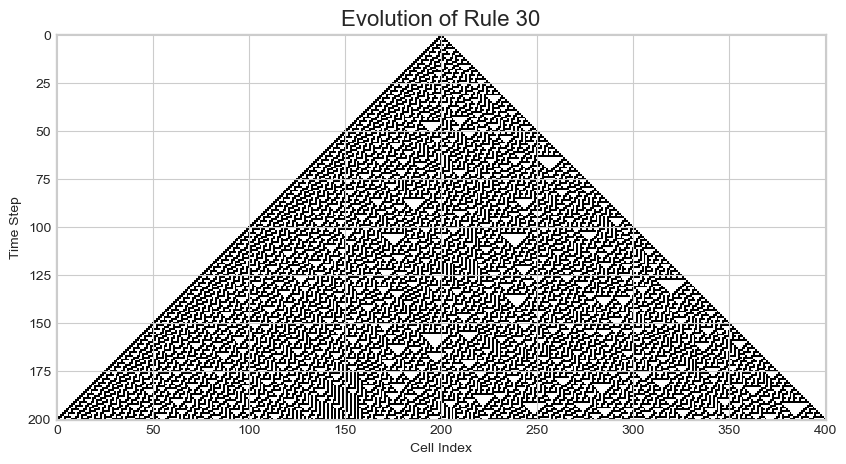

In [49]:
# ==============================================================================
# Module 1: Cellular Automaton Simulator and Visualization
# ==============================================================================

class ElementaryCellularAutomaton:
    """A simulator for Elementary Cellular Automata (ECA)."""
    def __init__(self, rule_number: int, size: int = 100):
        # Parameter check
        if not 0 <= rule_number <= 255:
            raise ValueError("Rule number must be between 0 and 255.")
        self.rule_number = rule_number
        self.size = size
        # Convert rule number into an 8-bit binary lookup table
        self.rule_table = np.array([int(x) for x in f'{rule_number:08b}'], dtype=np.uint8)
        self.state = None
        self.history = []

    def initialize(self, initial_state: np.ndarray = None):
        """Initialize the automaton state."""
        if initial_state is None:
            # If no initial state, use a random state
            self.state = np.random.randint(0, 2, self.size, dtype=np.uint8)
        else:
            self.state = initial_state.astype(np.uint8)
        self.history = [self.state.copy()]

    def evolve(self, steps: int = 1):
        """Evolve the automaton for a given number of steps."""
        if self.state is None:
            raise RuntimeError("You must call initialize() before evolving.")
        for _ in range(steps):
            # Use np.roll to implement periodic boundary conditions
            left_neighbors = np.roll(self.state, 1)
            right_neighbors = np.roll(self.state, -1)
            # Encode neighborhood as an index 0–7
            indices = 4 * left_neighbors + 2 * self.state + 1 * right_neighbors
            # Lookup in the rule table to update the state
            self.state = self.rule_table[7 - indices]
            self.history.append(self.state.copy())

def plot_evolution(history: np.ndarray, rule_number: int):
    """Visualization function for plotting the evolution history."""
    fig, ax = plt.subplots(figsize=(10, 10 * (history.shape[0] / history.shape[1])))
    ax.imshow(history, cmap='binary', interpolation='nearest')
    ax.set_title(f"Evolution of Rule {rule_number}", fontsize=16)
    ax.set_xlabel("Cell Index")
    ax.set_ylabel("Time Step")
    plt.show()

# --- Simulation and Visualization Example ---
RULE_TO_VISUALIZE = 30
GRID_SIZE = 401
TIME_STEPS = 200

# 1. Create instance
eca_vis = ElementaryCellularAutomaton(rule_number=RULE_TO_VISUALIZE, size=GRID_SIZE)
# 2. Create an initial state with a single center cell
initial_state = np.zeros(GRID_SIZE, dtype=np.uint8)
initial_state[GRID_SIZE // 2] = 1
# 3. Run simulation and plot
eca_vis.initialize(initial_state=initial_state)
eca_vis.evolve(steps=TIME_STEPS)
evolution_history = np.array(eca_vis.history)

print(f"Generating evolution plot for Rule {RULE_TO_VISUALIZE}...")
plot_evolution(evolution_history, RULE_TO_VISUALIZE)



## Module 2: Quantifying Chaos — Hamming Distance Time Series

A core feature of chaotic systems is their **sensitivity to initial conditions**.  
A tiny perturbation can grow rapidly over time. We can measure this sensitivity through a **“twin experiment”**:

1. Create two identical automata, **A** and **B**.  
2. Let them evolve synchronously for a short period to eliminate boundary effects.  
3. Flip a single cell at the center of **B** (changing 0 → 1 or 1 → 0) to introduce a small perturbation.  
4. Continue evolving **A** and **B** synchronously, and at each step compute the **Hamming distance** (the number of cells that differ between their states).  

This process yields a **Hamming distance time series**, which reveals how the perturbation propagates, saturates, or vanishes.  
The resulting time series will serve as the basis for our later classification algorithm.


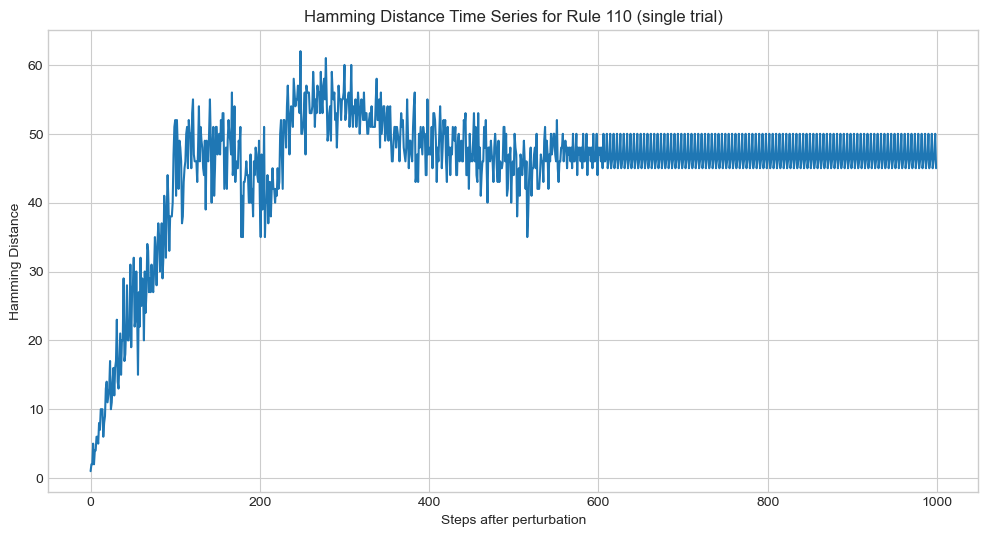

In [22]:
# ==============================================================================
# Module 2: Hamming Distance Analysis
# ==============================================================================

def hamming_distance(arr1: np.ndarray, arr2: np.ndarray) -> int:
    """Compute the Hamming distance between two arrays."""
    return np.count_nonzero(arr1 != arr2)

def run_single_trial(rule_number: int, size: int, duration: int, transient_period: int) -> np.ndarray:
    """Run a twin experiment and generate a Hamming distance time series."""
    # 1. Create two identical automata A and B
    eca_A = ElementaryCellularAutomaton(rule_number, size)
    eca_A.initialize()  # random initial state
    eca_B = ElementaryCellularAutomaton(rule_number, size)
    eca_B.initialize(initial_state=eca_A.state.copy())

    # 2. Evolve both to remove transient boundary effects
    eca_A.evolve(steps=transient_period)
    eca_B.evolve(steps=transient_period)
    
    # 3. Introduce a single perturbation at the center of B
    perturb_idx = size // 2
    eca_B.state[perturb_idx] = 1 - eca_B.state[perturb_idx]

    # 4. Continue evolving and record the Hamming distance
    hamming_ts = []
    for _ in range(duration):
        eca_A.evolve()
        eca_B.evolve()
        dist = hamming_distance(eca_A.state, eca_B.state)
        hamming_ts.append(dist)
        
    return np.array(hamming_ts)

# --- Example: Generate and plot a Hamming distance time series ---
RULE_FOR_TS = 110
ts_example = run_single_trial(rule_number=RULE_FOR_TS, size=100, duration=1000, transient_period=15)

plt.figure(figsize=(12, 6))
plt.plot(ts_example)
plt.title(f"Hamming Distance Time Series for Rule {RULE_FOR_TS} (single trial)")
plt.xlabel("Steps after perturbation")
plt.ylabel("Hamming Distance")
plt.show()


## Module 3: Intelligent Classifier — Interpreting Time Series

Now that we have the Hamming distance time series, how can we automatically determine the rule type?  
We build a multi-step intelligent classifier `characterize_series`.

Logic:

1. **Detect periodicity**: Use FFT to check whether the series contains stable, repeating patterns (key for distinguishing periodic vs. chaotic).
2. **Identify transients**: Check if the series shows “complex first, then simple,” indicating **Transient (T)** behavior.
3. **Integrate decisions**: Combine the above signals and the stability of the tail segment to assign one of:
   - **Class 1 (fixed point)**  
   - **LP (low period)**  
   - **HP (high period)**  
   - **C (chaotic)**  
   - **T (transient)**  
   - **U (ultra-long Period)**


In [24]:
# ==============================================================================
# Module 3: Time Series Analysis and Classification Algorithm
# ==============================================================================

def detect_periodicity(ts: np.ndarray, min_period: int = 2, significance: float = 12.0) -> int | None:
    """Core tool 1: Detect the dominant period in a time series using FFT."""
    n = len(ts)
    if n < min_period * 2: 
        return None
    
    # Remove DC component and check for constant sequence
    ts = ts - np.mean(ts)
    if np.all(np.abs(ts) < 1e-6): 
        return 1  # fixed point, period = 1

    # Compute power spectrum
    fft_power = np.abs(np.fft.rfft(ts))**2
    fft_freq = np.fft.rfftfreq(n)
    
    # Ignore high frequencies and DC component
    fft_power[fft_freq > 1.0 / min_period] = 0
    fft_power[0] = 0

    if np.all(fft_power < 1e-9): 
        return None

    # Find the most significant peak
    peak_idx = np.argmax(fft_power)
    peak_power = fft_power[peak_idx]

    # Check if the peak is sufficiently “prominent”
    mean_power = (np.sum(fft_power) - peak_power) / (len(fft_power) - 1)
    if mean_power < 1e-9 or peak_power / mean_power < significance:
        return None

    # Calculate period
    dominant_freq = fft_freq[peak_idx]
    if dominant_freq < 1e-9: 
        return None
    period = int(round(1 / dominant_freq))

    # Avoid unrealistically large periods
    if period > n // 2: 
        return None
    return period

def is_transient(ts: np.ndarray, tail_len: int = 400, var_ratio: float = 5.0) -> bool:
    """Core tool 2: Detect transient chaos (complex first, then simple)."""
    if len(ts) < tail_len * 2: 
        return False
    tail = ts[-tail_len:]
    head = ts[:-tail_len]
    std_tail = np.std(tail)
    std_head = np.std(head)

    # Condition 1: the head must be much more irregular than the tail
    if std_tail < 1e-6:
        if std_head < 2.0: 
            return False
    elif (std_head / std_tail) < var_ratio:
        return False
    
    # Condition 2: the tail itself must be simple (stable or short-periodic)
    period_in_tail = detect_periodicity(tail, significance=8.0)
    if period_in_tail is None and std_tail > 2.0:
        return False
        
    # Condition 3: the full series should not be classified as a stable long-period
    if detect_periodicity(ts, significance=10.0) is not None:
        return False
        
    return True

def characterize_series(ts: np.ndarray, L: int, tail_len: int = 400) -> str:
    """Final classifier: integrate all tools to classify a single time series."""
    # 1. Trivial case: perturbation disappears completely
    if np.all(ts == 0): 
        return '1'
    
    # 2. First, check global periodicity
    period = detect_periodicity(ts, significance=12.0)
    if period is not None:
        if period <= 20: 
            return 'LP'   # Low period
        if 20 < period < 5 * L: 
            return 'HP'   # High period
        if period >= 5 * L: 
            return 'C'    # Chaos (effectively infinite period)
        
    # 3. If no global periodicity, check for transient chaos
    if is_transient(ts, tail_len=tail_len):
        return 'T'
        
    # 4. Distinguish between stabilized short-period and sustained chaos
    if len(ts) > tail_len:
        tail = ts[-tail_len:]
        std_tail = np.std(tail)
        period_in_tail = detect_periodicity(tail, significance=8.0)
        if std_tail < 2.0 or (period_in_tail is not None and period_in_tail <= 20):
            return 'LP'

    # 5. Otherwise, classify as chaotic
    return 'C'
    

## Module 4: Final Validation — Reproducing Paper Results

We now have the complete toolchain, from simulation to classification.  
It is time to perform the final, large-scale validation.

We will define a `classify_rule` function that runs multiple independent twin experiments (e.g., 15 trials) for the same rule.  
The final classification is then decided using the **“most complex wins”** principle.  
For example, if 14 trials produce `'LP'` but 1 trial produces `'C'`, the final classification is `'C'`, since this demonstrates the rule’s ability to generate chaotic behavior.

Finally, we will apply this function to automatically classify all the rules mentioned in the reference paper, compare our results with the official classifications, and compute the overall accuracy.


In [25]:
# ==============================================================================
# Module 4: Automated Classification and Final Validation
# ==============================================================================

# Define complexity hierarchy for the “most complex wins” principle
COMPLEXITY_HIERARCHY = {'T': 5, 'U': 4, 'C': 3, 'HP': 2, 'LP': 1, '1': 0}

def classify_rule(rule_number: int, num_trials: int = 15, size: int = 100, 
                  duration: int = 3000, transient_period: int = 15) -> str:
    """
    Run multiple trials for a given rule and return the final classification.
    """
    results = []
    # Use tqdm to show progress bar
    for _ in tqdm(range(num_trials), desc=f"Classifying Rule {rule_number}", leave=False, ncols=100):
        ts = run_single_trial(rule_number, size, duration, transient_period)
        classification = characterize_series(ts, size)
        results.append(classification)
    
    if not results: 
        return "Error"
        
    # Core: select the most complex result as the final classification
    most_complex_result = max(results, key=lambda r: COMPLEXITY_HIERARCHY.get(r, -1))
    
    return most_complex_result

def verify_all_rules_from_paper():
    """
    Validate our classification algorithm against the paper results.
    """
    # Subset of rules and their classifications from the paper 
    # (U = ultra-long period, our algorithm maps it to C)
    paper_results_full = {
        0: '1', 1: 'LP', 2: 'LP', 3: 'LP', 4: 'LP', 5: 'LP', 6: 'LP', 7: 'LP',
        8: '1', 9: 'LP', 10: 'LP', 11: 'LP', 12: 'LP', 13: 'LP', 14: 'LP',
        15: 'LP', 18: 'C', 19: 'LP', 22: 'C', 23: 'LP', 24: 'LP', 25: 'HP',
        26: 'LP', 27: 'LP', 28: 'LP', 29: 'LP', 30: 'C', 32: '1', 33: 'LP',
        34: 'LP', 35: 'LP', 36: 'LP', 37: 'LP', 38: 'LP', 40: '1', 41: 'T',
        42: 'LP', 43: 'LP', 44: 'LP', 45: 'C', 46: 'LP', 50: 'LP', 51: 'LP',
        54: 'T', 56: 'LP', 57: 'LP', 58: 'LP', 60: 'C', # Paper: U
        62: 'HP', 72: 'LP', 73: 'T', 74: 'LP', 76: 'LP', 77: 'LP', 78: 'LP',
        90: 'C', # Paper: U
        94: 'LP', 104: 'LP', 105: 'C', # Paper: U
        106: 'C', 108: 'LP', 110: 'T', 122: 'C', 126: 'C', 128: '1', 130: 'LP',
        132: 'LP', 134: 'LP', 136: '1', 138: 'LP', 140: 'LP', 142: 'LP',
        146: 'C', 150: 'C', # Paper: U
        152: 'LP', 154: 'LP', 156: 'LP', 160: '1', 162: 'LP',
        164: 'LP', 168: '1', 170: 'LP', 172: 'LP', 178: 'LP', 184: 'LP',
        200: 'LP', 204: 'LP', 232: 'LP'
    }

    rules_to_test = sorted(paper_results_full.keys())
    correct_count = 0

    print("Starting validation of all unique rules from the paper:")
    print("-" * 65)
    print(f"{'Rule':<10} | {'Paper Classification':<20} | {'Our Output':<20} | {'Match'}")
    print("-" * 65)

    for rule in rules_to_test:
        classification = classify_rule(rule, num_trials=15, duration=3000)
        paper_subclass = paper_results_full.get(rule, "N/A")
        
        # Map U to C for fair comparison
        if paper_subclass == 'U':
            paper_subclass = 'C'

        match = "✅" if classification == paper_subclass else "❌"
        if match == "✅":
            correct_count += 1
        print(f"{rule:<10} | {paper_results_full.get(rule, 'N/A'):<20} | {classification:<20} | {match}")

    print("-" * 65)
    accuracy = (correct_count / len(rules_to_test)) * 100
    print(f"Total number of rules tested: {len(rules_to_test)}")
    print(f"Number of correct matches: {correct_count}")
    print(f"Accuracy: {accuracy:.2f}%")

if __name__ == '__main__':
    # Note: running all rules can be very time-consuming!
    # For a quick demo, you can uncomment the following line to test a single rule:
    # print(f"Final classification for Rule 110: {classify_rule(110)}")
    
    # Run the full validation process
    verify_all_rules_from_paper()


Starting validation of all unique rules from the paper:
-----------------------------------------------------------------
Rule       | Paper Classification | Our Output           | Match
-----------------------------------------------------------------


0          | 1                    | 1                    | ✅


1          | LP                   | LP                   | ✅


2          | LP                   | LP                   | ✅


3          | LP                   | LP                   | ✅


4          | LP                   | LP                   | ✅


5          | LP                   | LP                   | ✅


6          | LP                   | LP                   | ✅


7          | LP                   | LP                   | ✅


8          | 1                    | 1                    | ✅


9          | LP                   | T                    | ❌


10         | LP                   | LP                   | ✅


11         | LP                   | LP                   | ✅


12         | LP                   | LP                   | ✅


13         | LP                   | LP                   | ✅


14         | LP                   | LP                   | ✅


15         | LP                   | LP                   | ✅


18         | C                    | C                    | ✅


19         | LP                   | LP                   | ✅


22         | C                    | C                    | ✅


23         | LP                   | LP                   | ✅


24         | LP                   | LP                   | ✅


25         | HP                   | T                    | ❌


26         | LP                   | LP                   | ✅


27         | LP                   | LP                   | ✅


28         | LP                   | LP                   | ✅


29         | LP                   | LP                   | ✅


30         | C                    | C                    | ✅


32         | 1                    | 1                    | ✅


33         | LP                   | LP                   | ✅


34         | LP                   | LP                   | ✅


35         | LP                   | LP                   | ✅


36         | LP                   | LP                   | ✅


37         | LP                   | LP                   | ✅


38         | LP                   | LP                   | ✅


40         | 1                    | 1                    | ✅


41         | T                    | LP                   | ❌


42         | LP                   | LP                   | ✅


43         | LP                   | T                    | ❌


44         | LP                   | LP                   | ✅


45         | C                    | C                    | ✅


46         | LP                   | LP                   | ✅


50         | LP                   | LP                   | ✅


51         | LP                   | LP                   | ✅


54         | T                    | C                    | ❌


56         | LP                   | LP                   | ✅


57         | LP                   | T                    | ❌


58         | LP                   | LP                   | ✅


60         | C                    | LP                   | ❌


62         | HP                   | LP                   | ❌


72         | LP                   | LP                   | ✅


73         | T                    | HP                   | ❌


74         | LP                   | LP                   | ✅


76         | LP                   | LP                   | ✅


77         | LP                   | LP                   | ✅


78         | LP                   | LP                   | ✅


90         | C                    | LP                   | ❌


94         | LP                   | LP                   | ✅


104        | LP                   | LP                   | ✅


105        | C                    | LP                   | ❌


106        | C                    | C                    | ✅


108        | LP                   | LP                   | ✅


110        | T                    | T                    | ✅


122        | C                    | C                    | ✅


126        | C                    | C                    | ✅


128        | 1                    | 1                    | ✅


130        | LP                   | LP                   | ✅


132        | LP                   | LP                   | ✅


134        | LP                   | LP                   | ✅


136        | 1                    | 1                    | ✅


138        | LP                   | LP                   | ✅


140        | LP                   | LP                   | ✅


142        | LP                   | T                    | ❌


146        | C                    | C                    | ✅


150        | C                    | LP                   | ❌


152        | LP                   | LP                   | ✅


154        | LP                   | LP                   | ✅


156        | LP                   | LP                   | ✅


160        | 1                    | 1                    | ✅


162        | LP                   | LP                   | ✅


164        | LP                   | LP                   | ✅


168        | 1                    | 1                    | ✅


170        | LP                   | LP                   | ✅


172        | LP                   | LP                   | ✅


178        | LP                   | LP                   | ✅


184        | LP                   | T                    | ❌


200        | LP                   | LP                   | ✅


204        | LP                   | LP                   | ✅


232        | LP                   | LP                   | ✅
-----------------------------------------------------------------
Total number of rules tested: 88
Number of correct matches: 74
Accuracy: 84.09%
